Необходимо построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона можно использовать ipython-ноутбук 002-digit.ipynb.
Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.
В качестве модели классификатора можно использовать любую известную модель, за исключением сверточных нейронных сетей.

**Критерии качества**

Метрика accuracy. Чтобы получить зачёт по работе работе, значение метрики должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

**Как сдавать**

Решение необходимо предоставить в виде** ipytnon-ноутбука** с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle: https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

In [2]:
train = pd.read_csv(os.path.join('../input', 'train.csv'))
test = pd.read_csv(os.path.join('../input', 'test.csv'))

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]

# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))
train_img.shape

(42000, 28, 28)

Визуализируем исходные данные

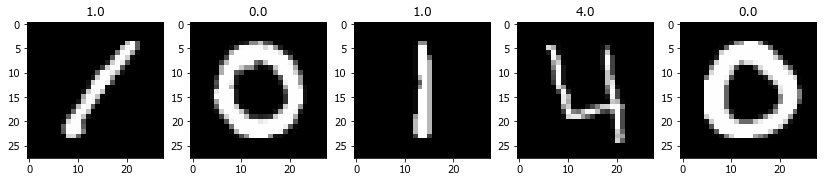

In [4]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

Повернем изображения

In [5]:
def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

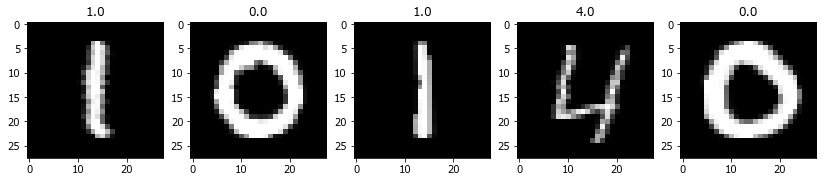

In [6]:
SZ = 28
train_img_deskew = []
for i in train_img:
    desk = deskew(i)
    train_img_deskew.append(desk)
test_img_deskew = []
for i in test_img:
    desk = deskew(i)
    test_img_deskew.append(desk)

fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img_deskew[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [7]:
train_sobel_x = np.zeros_like(train_img_deskew)
train_sobel_y = np.zeros_like(train_img_deskew)
for i in range(len(train_img_deskew)):
    train_sobel_x[i] = cv2.Sobel(train_img_deskew[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img_deskew[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
    
test_sobel_x = np.zeros_like(test_img_deskew)
test_sobel_y = np.zeros_like(test_img_deskew)
for i in range(len(test_img_deskew)):
    test_sobel_x[i] = cv2.Sobel(test_img_deskew[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img_deskew[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

Вычисляем угол и длину вектора градиента

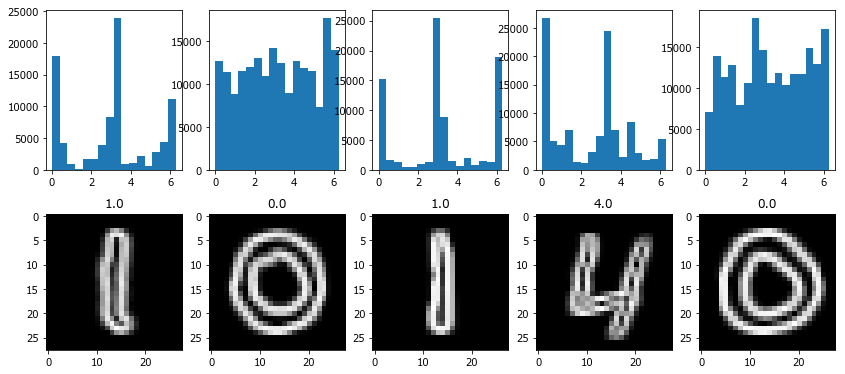

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

Вычисляем гистограммы градиентов с учетом длины вектора градиента.

In [9]:
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [10]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

Нормируем вектор гистограммы. L2 норма.

In [11]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]
train_hist.shape, test_hist.shape

((42000, 16), (28000, 16))

Разбиваем выборку на обучение и валидацию

In [12]:
from sklearn.model_selection import train_test_split

y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

In [13]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

Логистическая регрессия

In [14]:
model = LogisticRegression()
results = cross_val_score(model, x_train, y_train, cv=10)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 65.012% (1.270%)


In [17]:
grid = {'penalty': ['l1'],
        'C':[3.5, 4, 4.5, 5, 5.5, 6, 6.5]
       }
gridsearch = GridSearchCV(LogisticRegression(), grid, cv=5, n_jobs=-1)

In [18]:
gridsearch.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1'], 'C': [3.5, 4, 4.5, 5, 5.5, 6, 6.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
print(gridsearch.best_score_)
print(gridsearch.best_params_)
print(gridsearch.best_estimator_)

0.6552380952380953
{'C': 6, 'penalty': 'l1'}
LogisticRegression(C=6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [26]:
import lightgbm

train_data = lightgbm.Dataset(x_train, label=y_train)
test_data = lightgbm.Dataset(x_val, label=y_val)

params = {
    'application': 'multiclass',
    'objective': 'multiclass',
    'num_class': 10,
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 20,
    'learning_rate': 0.01,
    'verbose': 0}

In [27]:
light_class = lightgbm.train(params,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=10000,
                       early_stopping_rounds=500,
                       verbose_eval=500)

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's multi_logloss: 0.81982
[1000]	valid_0's multi_logloss: 0.749312
[1500]	valid_0's multi_logloss: 0.734277
[2000]	valid_0's multi_logloss: 0.729063
[2500]	valid_0's multi_logloss: 0.727905
Early stopping, best iteration is:
[2295]	valid_0's multi_logloss: 0.727451


In [28]:
best = light_class.best_iteration
predicted = light_class.predict(x_val, num_iteration=best)
predicted = np.argmax(predicted, axis=1)
report = classification_report(y_val, predicted)
print(report)

              precision    recall  f1-score   support

         0.0       0.59      0.61      0.60       816
         1.0       0.99      0.97      0.98       909
         2.0       0.61      0.56      0.58       846
         3.0       0.74      0.76      0.75       937
         4.0       0.79      0.78      0.79       839
         5.0       0.72      0.76      0.74       702
         6.0       0.69      0.75      0.72       785
         7.0       0.89      0.84      0.86       893
         8.0       0.61      0.61      0.61       835
         9.0       0.78      0.76      0.77       838

   micro avg       0.74      0.74      0.74      8400
   macro avg       0.74      0.74      0.74      8400
weighted avg       0.74      0.74      0.74      8400



HOG

In [66]:
winSize = (28,28)
blockSize = (8,8)
blockStride = (4,4)
cellSize = (4,4)
nbins = 8
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 2
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

In [67]:
instances = []
for img in train_img_deskew:
    cv_img = img.astype(np.uint8)
    descriptor = hog.compute(cv_img)
    if descriptor is None:
        descriptor = []
    else:
        descriptor = descriptor.ravel()
    instances.append(descriptor)

In [68]:
instances = np.array(instances)

In [69]:
train_hist = instances / np.linalg.norm(instances, axis=1)[:, None]

In [70]:
instances = []
for img in test_img_deskew:
    cv_img = img.astype(np.uint8)
    descriptor = hog.compute(cv_img)
    if descriptor is None:
        descriptor = []
    else:
        descriptor = descriptor.ravel()
    instances.append(descriptor)

In [71]:
instances = np.array(instances)

In [72]:
test_hist = instances / np.linalg.norm(instances, axis=1)[:, None]

In [73]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
                                 train_label,
                                 train_hist, 
                                 test_size=0.2,
                                 random_state=42)

In [92]:
import lightgbm as lgb

train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_val, label=y_val)

params = {
    'application': 'multiclass',
    'objective': 'multiclass',
    'num_class': 10,
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 10,
    'learning_rate': 0.05,
    'verbose': 0}

In [93]:
lgbm = lgb.train(params,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=1000,
                       early_stopping_rounds=300,
                       verbose_eval=300)

Training until validation scores don't improve for 300 rounds.
[300]	valid_0's multi_logloss: 0.0349238
[600]	valid_0's multi_logloss: 0.0349025
Early stopping, best iteration is:
[486]	valid_0's multi_logloss: 0.0346731


In [94]:
best = lgbm.best_iteration
predicted = lgbm.predict(x_val, num_iteration=best)
predicted = np.argmax(predicted, axis=1)
report = classification_report(y_val, predicted)
print(report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       816
         1.0       0.99      0.99      0.99       909
         2.0       0.99      1.00      0.99       846
         3.0       0.99      0.99      0.99       937
         4.0       0.99      0.98      0.99       839
         5.0       0.99      1.00      0.99       702
         6.0       0.99      0.99      0.99       785
         7.0       0.99      1.00      0.99       893
         8.0       0.98      0.99      0.99       835
         9.0       0.98      0.98      0.98       838

   micro avg       0.99      0.99      0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



Как видно из результатов, рукописное изображение нуля распознаётся моделью всегда.
Мы убедились, что HOG позволяет создать такое признаковое пространство, на основе которого возможно создание высокоточной модели.

In [91]:
pred_test = lgbm.predict(test_hist, num_iteration=best)
pred_test = np.argmax(pred_test, axis=1 )

with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [ ]:
http://joxi.ru/p27XqJ9UKWMYwA